In [1]:
!pip install reliability

Defaulting to user installation because normal site-packages is not writeable


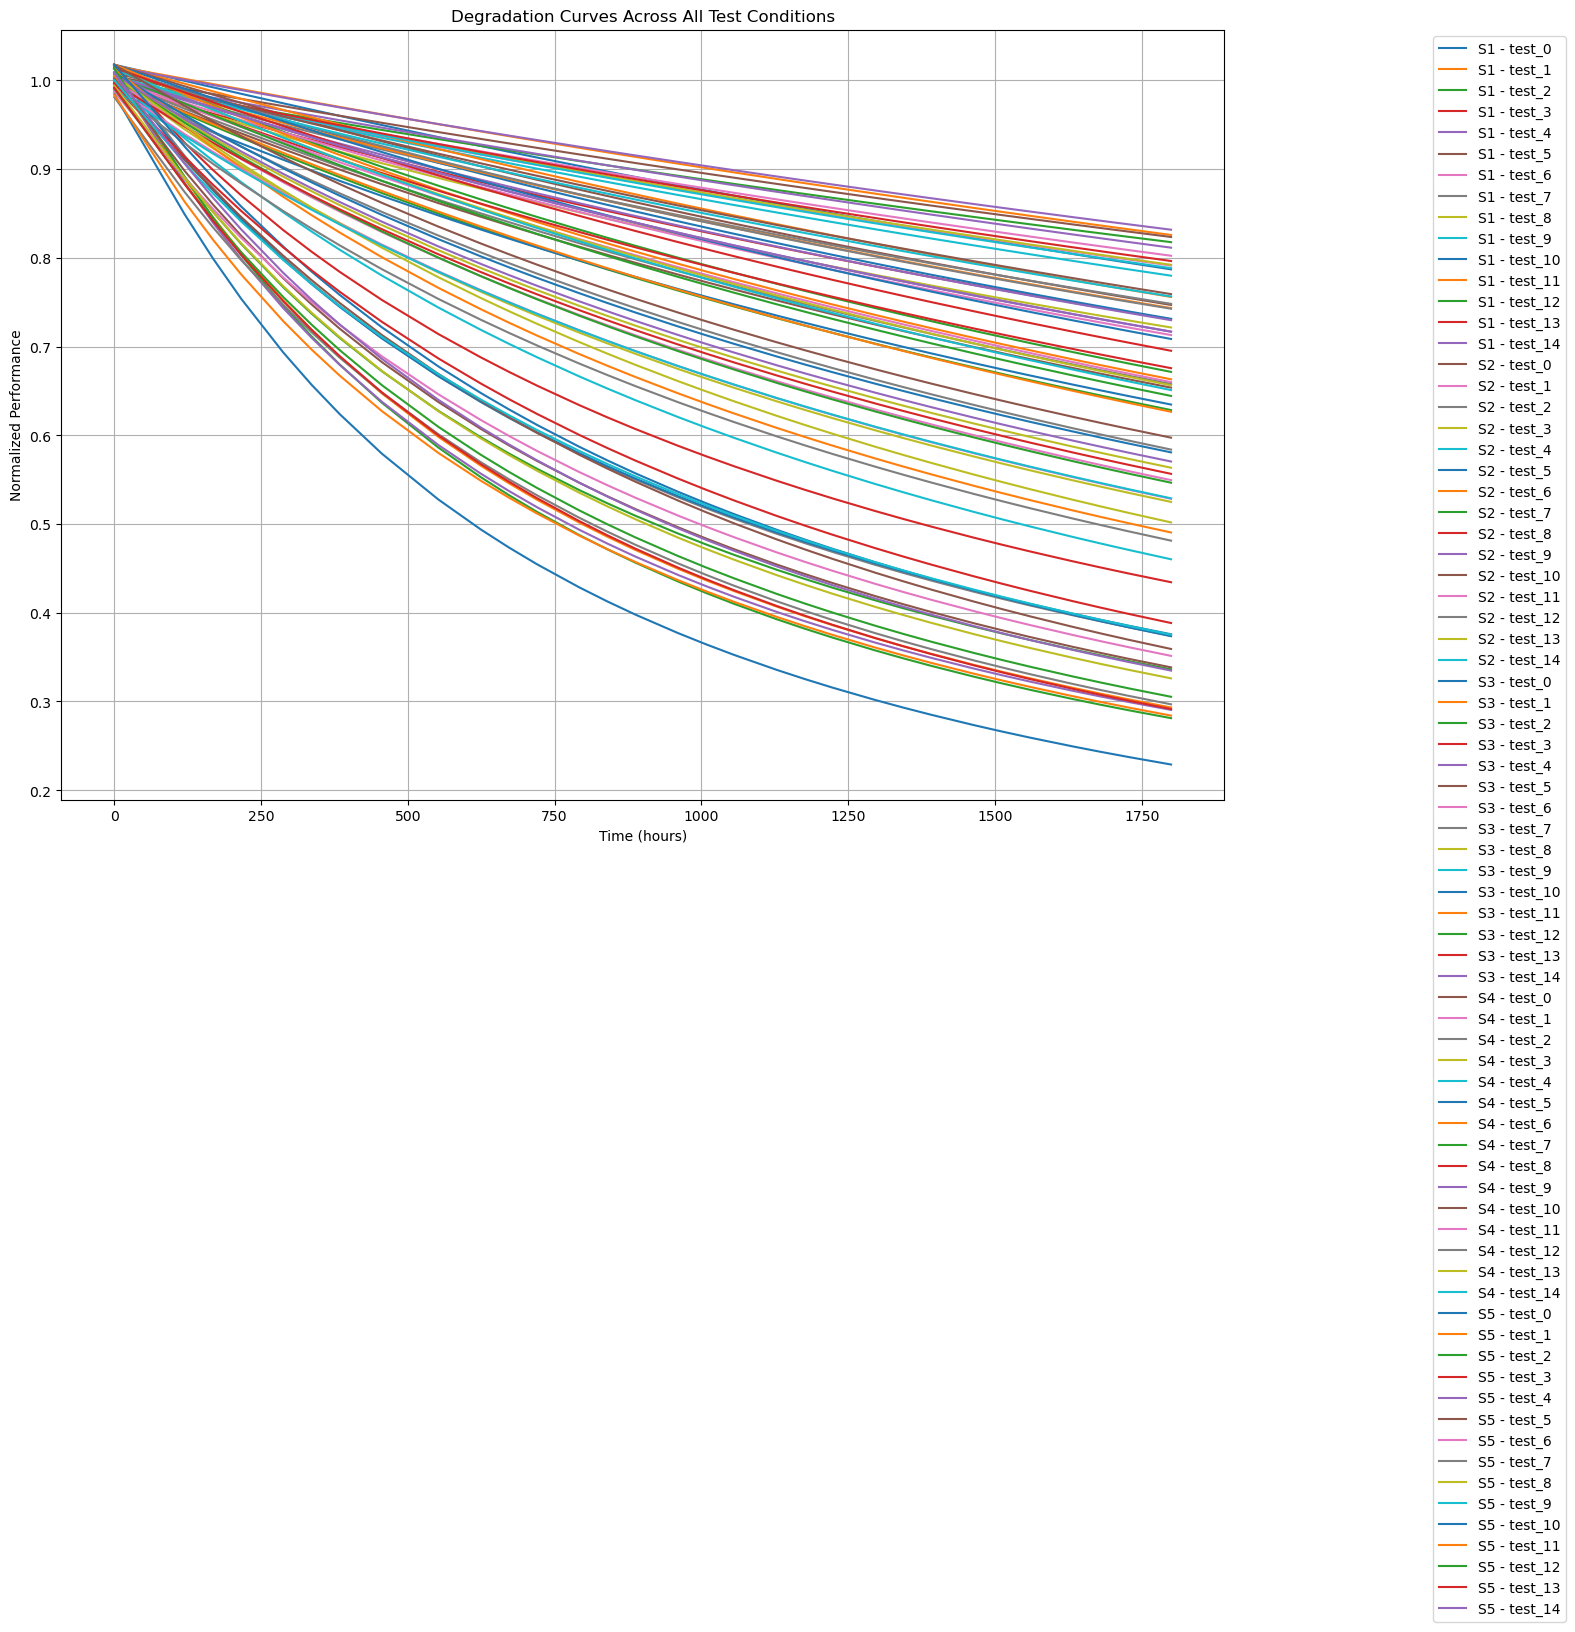

LED Lifetime Predictions:
   Test Condition  Predicted Lifetime (hours)
0     S1 - test_0                         NaN
1     S1 - test_1                         NaN
2     S1 - test_2                         NaN
3     S1 - test_3                       624.0
4     S1 - test_4                         NaN
..            ...                         ...
70   S5 - test_10                       288.0
71   S5 - test_11                       336.0
72   S5 - test_12                       384.0
73   S5 - test_13                       384.0
74   S5 - test_14                       456.0

[75 rows x 2 columns]


In [4]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
file_paths = {
    "S1": "degradation_data/S1.csv",  # Replace with actual file paths if different
    "S2": "degradation_data/S2.csv",
    "S3": "degradation_data/S3.csv",
    "S4": "degradation_data/S4.csv",
    "S5": "degradation_data/S5.csv",
}

# Load all files into a dictionary of DataFrames
dataframes = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Visualize degradation curves
plt.figure(figsize=(15, 10))

for name, df in dataframes.items():
    for column in df.columns[1:]:  # Exclude 'time' column
        plt.plot(df['time'], df[column], label=f'{name} - {column}')

plt.title('Degradation Curves Across All Test Conditions')
plt.xlabel('Time (hours)')
plt.ylabel('Normalized Performance')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid()
plt.show()

# Define the failure threshold (e.g., 70% of initial performance)
failure_threshold = 0.7

# Store lifetime predictions
lifetime_predictions = {}

# Calculate the time when performance falls below the threshold for each test condition
for dataset_name, df in dataframes.items():
    for column in df.columns[1:]:  # Exclude 'time'
        degradation_data = df[column]
        time_data = df['time']

        # Identify failure times based on threshold
        failure_times = time_data[degradation_data <= failure_threshold]
        if not failure_times.empty:
            failure_time = failure_times.iloc[0]
        else:
            failure_time = None

        # Store results
        lifetime_predictions[f"{dataset_name} - {column}"] = failure_time

# Convert predictions to a DataFrame for better readability
lifetime_df = pd.DataFrame(
    list(lifetime_predictions.items()), columns=["Test Condition", "Predicted Lifetime (hours)"]
)

# Display the predictions
print("LED Lifetime Predictions:")
print(lifetime_df)

# Optionally save the results to a CSV file
lifetime_df.to_csv("LED_Lifetime_Predictions.csv", index=False)


<>:115: SyntaxWarning: invalid escape sequence '\S'
<>:115: SyntaxWarning: invalid escape sequence '\S'
C:\Users\eusta\AppData\Local\Temp\ipykernel_1548\4195616122.py:115: SyntaxWarning: invalid escape sequence '\S'
  process_trend_and_failure_time("degradation_data\S1.csv", failure_threshold=0.5)
c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_0
Could not fit Exponential for test_1
Could not fit Exponential for test_2
Could not fit Exponential for test_3
Could not fit Exponential for test_4
Could not fit Exponential for test_5
Could not fit Exponential for test_6
Could not fit Exponential for test_7
Could not fit Exponential for test_8
Could not fit Exponential for test_9
Could not fit Exponential for test_10
Could not fit Exponential for test_11
Could not fit Exponential for test_12
Could not fit Exponential for test_13
Could not fit Exponential for test_14


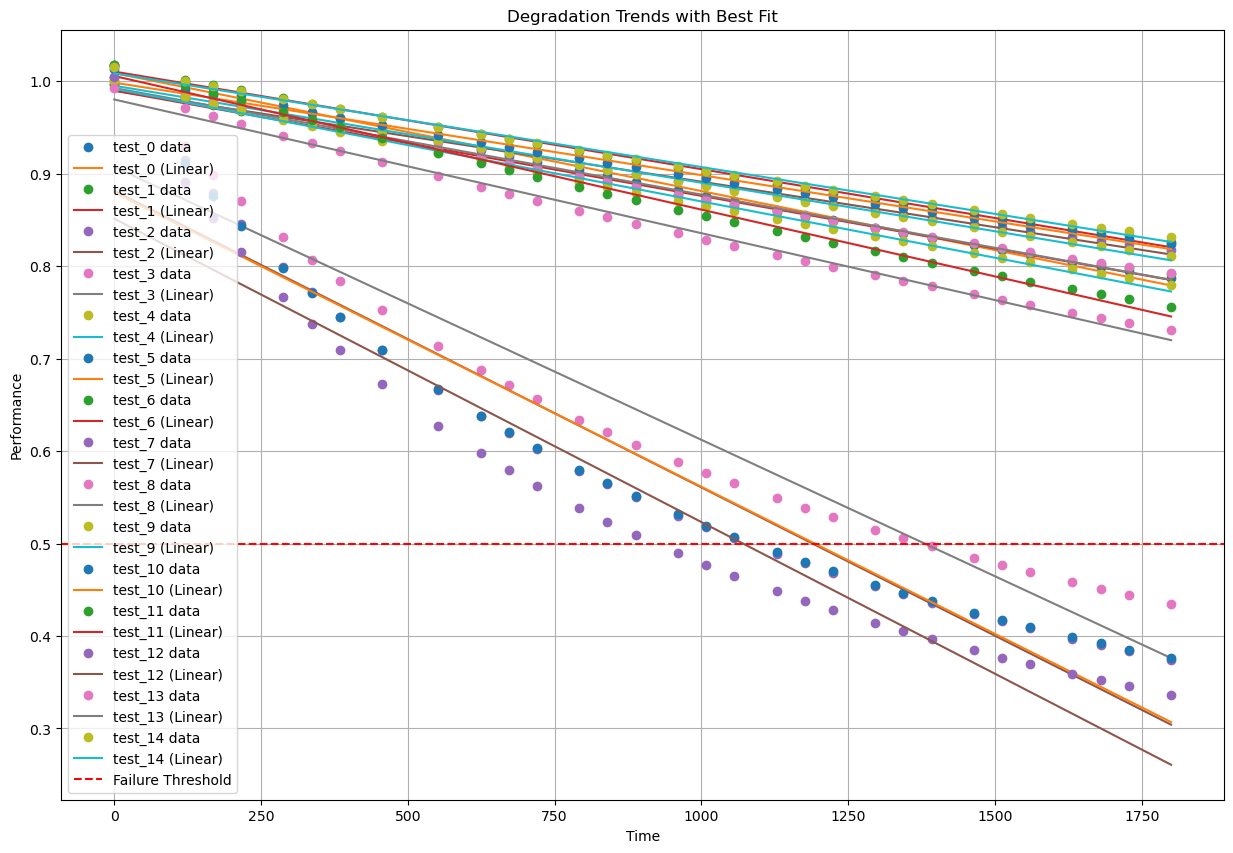

   Experiment Best Model                               Model Parameters  \
0      test_0     Linear   [-0.0001276483575959954, 1.0088881983926519]   
1      test_1     Linear  [-0.00010554948581826324, 1.0104522898990882]   
2      test_2     Linear    [-9.83968037620637e-05, 0.9897549647339309]   
3      test_3     Linear  [-0.00029510648582553036, 0.9073169464785684]   
4      test_4     Linear   [-0.0001049077667851109, 0.9951587550600177]   
5      test_5     Linear   [-0.0001000478804407795, 0.9985229201976481]   
6      test_6     Linear  [-0.00011382305247357775, 0.9898930060238904]   
7      test_7     Linear   [-0.0003208028622820983, 0.8815410218309113]   
8      test_8     Linear  [-0.00011520090614530206, 0.9926518436811876]   
9      test_9     Linear  [-0.00012178679989897207, 0.9918269798716052]   
10    test_10     Linear  [-0.00031812221983772664, 0.8795195952411085]   
11    test_11     Linear  [-0.00014448834192109706, 1.0056734219860473]   
12    test_12     Linear 

In [5]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define different trend models
def linear_trend(t, a, b):
    return a * t + b

def exponential_trend(t, a, b):
    return a * np.exp(b * t)

def polynomial_trend(t, a, b, c):
    return a * t**2 + b * t + c

def logarithmic_trend(t, a, b):
    return a * np.log(t + 1e-6) + b  # Avoid log(0) errors

# List of models to evaluate
MODELS = {
    "Linear": linear_trend,
    "Exponential": exponential_trend,
    
    "Logarithmic": logarithmic_trend,
}

def process_trend_and_failure_time(file_path, failure_threshold=0.5):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    if "time" not in df.columns:
        raise ValueError("The dataset must have a 'time' column.")
    
    time = df["time"]
    experiments = df.drop(columns=["time"]).columns

    results = []
    plt.figure(figsize=(15, 10))

    for experiment in experiments:
        degradation = df[experiment].dropna()
        valid_time = time[:len(degradation)]

        if degradation.empty:
            print(f"Skipping {experiment}: No valid data points.")
            continue

        best_model = None
        best_params = None
        best_error = np.inf
        best_failure_time = None

        # Fit all models and evaluate
        for model_name, model_func in MODELS.items():
            try:
                # Fit the model
                params, _ = curve_fit(model_func, valid_time, degradation, maxfev=5000)
                
                # Calculate error (residual sum of squares)
                predictions = model_func(valid_time, *params)
                error = np.sum((degradation - predictions)**2)

                # Estimate failure time
                failure_time = None
                if model_name == "Polynomial":
                    # Polynomial: solve for time when the trend reaches the threshold
                    roots = np.roots([params[0], params[1], params[2] - failure_threshold])
                    valid_roots = roots[np.isreal(roots) & (roots > 0)].real
                    failure_time = np.min(valid_roots) if valid_roots.size > 0 else np.inf
                elif model_name == "Logarithmic":
                    failure_time = (failure_threshold - params[1]) / params[0] if params[0] != 0 else np.inf
                else:
                    failure_time = (failure_threshold - params[1]) / params[0] if params[0] != 0 else np.inf

                # Track the best model
                if error < best_error:
                    best_model = model_name
                    best_params = params
                    best_error = error
                    best_failure_time = failure_time

            except RuntimeError:
                print(f"Could not fit {model_name} for {experiment}")
                continue

        # Plot the best fit
        if best_model:
            plt.plot(valid_time, degradation, 'o', label=f"{experiment} data")
            plt.plot(valid_time, MODELS[best_model](valid_time, *best_params), '-', label=f"{experiment} ({best_model})")

            # Store results
            results.append({
                "Experiment": experiment,
                "Best Model": best_model,
                "Model Parameters": best_params,
                "Error": best_error,
                "Estimated Failure Time": best_failure_time,
            })

    # Finalize the plot
    plt.axhline(failure_threshold, color='r', linestyle='--', label="Failure Threshold")
    plt.title("Degradation Trends with Best Fit")
    plt.xlabel("Time")
    plt.ylabel("Performance")
    plt.legend()
    plt.grid()
    plt.show()

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    print(results_df)
    results_df.to_csv("Trend_Failure_Times_All_Models.csv", index=False)

# Example Usage
process_trend_and_failure_time("degradation_data\S1.csv", failure_threshold=0.5)


<>:117: SyntaxWarning: invalid escape sequence '\S'
<>:117: SyntaxWarning: invalid escape sequence '\S'
C:\Users\eusta\AppData\Local\Temp\ipykernel_1548\3259365135.py:117: SyntaxWarning: invalid escape sequence '\S'
  process_trend_and_failure_time("degradation_data\S1.csv", failure_threshold=0.5)
c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_0


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_1


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_2


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_3


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_4


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_5


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_6


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_7


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_8


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_9


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_10


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_11


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_12


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_13


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit Exponential for test_14


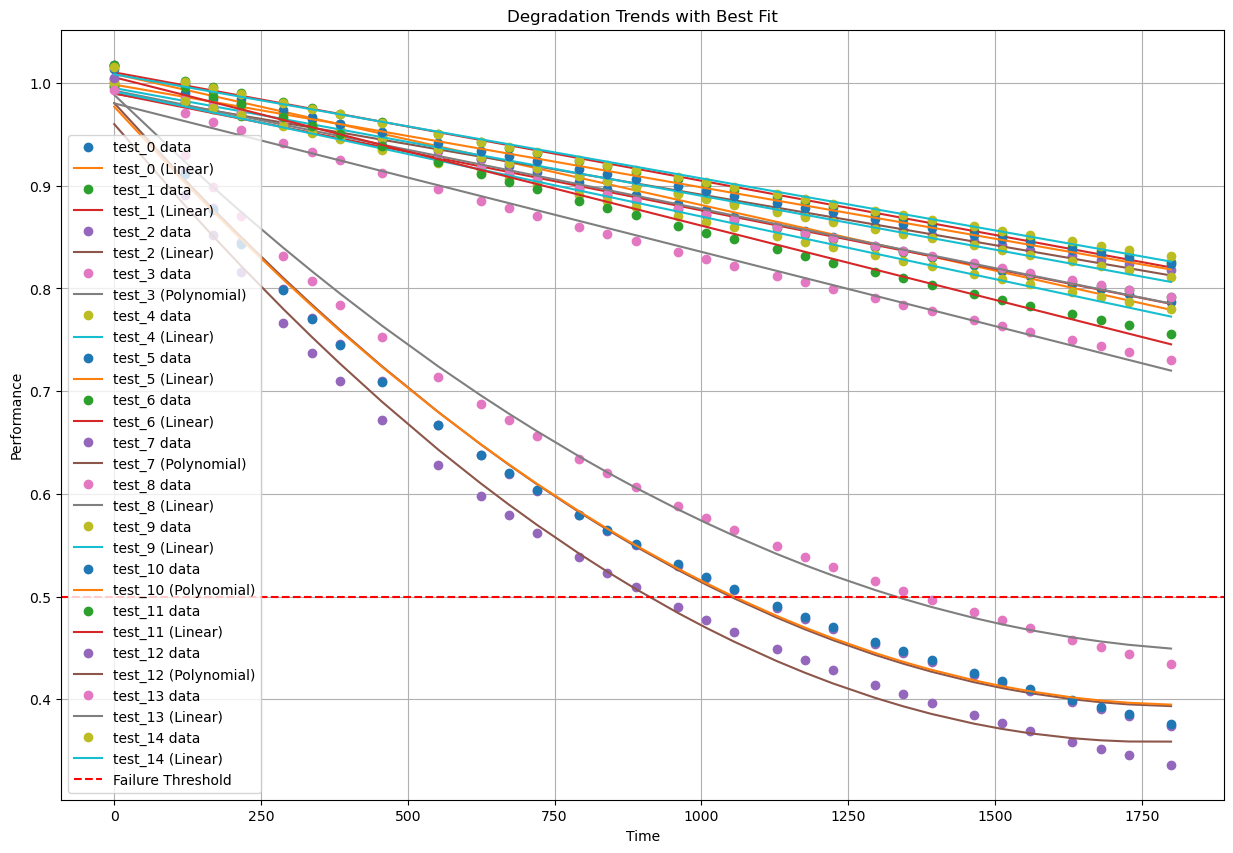

   Experiment  Best Model                                   Model Parameters  \
0      test_0      Linear       [-0.0001276483575959954, 1.0088881983926519]   
1      test_1      Linear      [-0.00010554948581826324, 1.0104522898990882]   
2      test_2      Linear        [-9.83968037620637e-05, 0.9897549647339309]   
3      test_3  Polynomial  [1.438810104034299e-07, -0.0005585479594433434...   
4      test_4      Linear       [-0.0001049077667851109, 0.9951587550600177]   
5      test_5      Linear       [-0.0001000478804407795, 0.9985229201976481]   
6      test_6      Linear      [-0.00011382305247357775, 0.9898930060238904]   
7      test_7  Polynomial  [1.7534613022697045e-07, -0.000641855951898874...   
8      test_8      Linear      [-0.00011520090614530206, 0.9926518436811876]   
9      test_9      Linear      [-0.00012178679989897207, 0.9918269798716052]   
10    test_10  Polynomial  [1.7267715843368687e-07, -0.000634288508817773...   
11    test_11      Linear      [-0.00014

In [6]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define different trend models
def linear_trend(t, a, b):
    return a * t + b

def exponential_trend(t, a, b):
    return a * np.exp(b * t)

def polynomial_trend(t, a, b, c):
    return a * t**2 + b * t + c

def logarithmic_trend(t, a, b):
    return a * np.log(t + 1e-6) + b  # Avoid log(0) errors

# List of models to evaluate
MODELS = {
    "Linear": linear_trend,
    "Exponential": exponential_trend,
    "Polynomial": polynomial_trend,
    "Logarithmic": logarithmic_trend,
}

def process_trend_and_failure_time(file_path, failure_threshold=0.5):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    if "time" not in df.columns:
        raise ValueError("The dataset must have a 'time' column.")
    
    time = df["time"]
    experiments = df.drop(columns=["time"]).columns

    results = []
    plt.figure(figsize=(15, 10))

    for experiment in experiments:
        degradation = df[experiment].dropna()
        valid_time = time[:len(degradation)]

        if degradation.empty:
            print(f"Skipping {experiment}: No valid data points.")
            continue

        best_model = None
        best_params = None
        best_error = np.inf
        best_failure_time = np.inf

        # Fit all models and evaluate
        for model_name, model_func in MODELS.items():
            try:
                # Fit the model
                params, _ = curve_fit(model_func, valid_time, degradation, maxfev=5000)
                
                # Calculate error (residual sum of squares)
                predictions = model_func(valid_time, *params)
                error = np.sum((degradation - predictions)**2)

                # Estimate failure time
                failure_time = np.inf
                if model_name == "Polynomial":
                    # Polynomial: solve for time when the trend reaches the threshold
                    roots = np.roots([params[0], params[1], params[2] - failure_threshold])
                    valid_roots = roots[np.isreal(roots) & (roots > 0)].real
                    failure_time = np.min(valid_roots) if valid_roots.size > 0 else np.inf
                elif model_name == "Logarithmic":
                    if params[0] != 0:
                        failure_time = (failure_threshold - params[1]) / params[0]
                else:
                    if params[0] != 0:
                        failure_time = (failure_threshold - params[1]) / params[0]

                # Only consider models with a finite failure time
                if failure_time != np.inf and error < best_error:
                    best_model = model_name
                    best_params = params
                    best_error = error
                    best_failure_time = failure_time

            except RuntimeError:
                print(f"Could not fit {model_name} for {experiment}")
                continue

        # Plot the best fit
        if best_model:
            plt.plot(valid_time, degradation, 'o', label=f"{experiment} data")
            plt.plot(valid_time, MODELS[best_model](valid_time, *best_params), '-', label=f"{experiment} ({best_model})")

            # Store results
            results.append({
                "Experiment": experiment,
                "Best Model": best_model,
                "Model Parameters": best_params,
                "Error": best_error,
                "Estimated Failure Time": best_failure_time,
            })

    # Finalize the plot
    plt.axhline(failure_threshold, color='r', linestyle='--', label="Failure Threshold")
    plt.title("Degradation Trends with Best Fit")
    plt.xlabel("Time")
    plt.ylabel("Performance")
    plt.legend()
    plt.grid()
    plt.show()

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    print(results_df)
    results_df.to_csv("Trend_Failure_Times_All_Models.csv", index=False)

# Example Usage
process_trend_and_failure_time("degradation_data\S1.csv", failure_threshold=0.5)


In [7]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from reliability.Fitters import Fit_Weibull_2P
from reliability.Distributions import Weibull_Distribution

# Load datasets
file_paths = {
    "S1": "degradation_data/S1.csv",  # Replace with actual file paths if different
    "S2": "degradation_data/S2.csv",
    "S3": "degradation_data/S3.csv",
    "S4": "degradation_data/S4.csv",
    "S5": "degradation_data/S5.csv",
}

# Load all files into a dictionary of DataFrames
dataframes = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Define the failure threshold (e.g., 70% of initial performance)
failure_threshold = 0.7

# Store lifetime predictions
lifetime_predictions = {}

# Analyze degradation data and fit Weibull models
for dataset_name, df in dataframes.items():
    for column in df.columns[1:]:  # Exclude 'time'
        degradation_data = df[column]
        time_data = df['time']

        # Identify the failure times (when degradation reaches the threshold)
        failure_times = time_data[degradation_data <= failure_threshold]
        if not failure_times.empty:
            failure_time = failure_times.iloc[0]
        else:
            failure_time = None

        # Fit a Weibull distribution to the degradation data
        if failure_time:
            failure_indices = time_data[degradation_data <= failure_threshold].index
            failure_data = time_data.loc[failure_indices].values
            fit = Fit_Weibull_2P(failures=failure_data, show_probability_plot=False)
            predicted_lifetime = fit.quantile(0.7)  # Quantile representing 70% survival
            
            # Store the predicted lifetime
            lifetime_predictions[f"{dataset_name} - {column}"] = predicted_lifetime

# Convert predictions to a DataFrame for better readability
lifetime_df = pd.DataFrame(
    list(lifetime_predictions.items()), columns=["Test Condition", "Predicted Lifetime (hours)"]
)

# Display predictions
print("LED Lifetime Predictions:")
print(lifetime_df)

# Optionally save the results to a CSV file
lifetime_df.to_csv("LED_Lifetime_Predictions_With_Weibull.csv", index=False)

# Visualize Weibull fits for a specific condition (optional)
# Example: Plot for the first dataset and first condition
example_condition = list(dataframes.keys())[0]
example_df = dataframes[example_condition]
example_column = example_df.columns[1]

fit_example = Fit_Weibull_2P(
    failures=example_df['time'][example_df[example_column] <= failure_threshold].values,
    show_probability_plot=True
)


Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 22/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         1335.53         77.8347   1191.36   1497.13
     Beta          3.8591        0.660278   2.75962   5.39664 

Goodness of fit    Value
 Log-likelihood -160.103
           AICc  324.837
            BIC  326.387
             AD 0.810783 

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\eusta\AppData\Local\Temp\ipykernel_1548\3010323716.py", line 43, in <module>
    predicted_lifetime = fit.quantile(0.7)  # Quantile representing 70% survival
                         ^^^^^^^^^^^^
AttributeError: 'Fit_Weibull_2P' object has no attribute 'quantile'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 2168, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\ultratb.py", line 1457, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [8]:
from reliability.Distributions import Weibull_Distribution

# Analyze degradation data and fit Weibull models
for dataset_name, df in dataframes.items():
    for column in df.columns[1:]:  # Exclude 'time'
        degradation_data = df[column]
        time_data = df['time']

        # Identify the failure times (when degradation reaches the threshold)
        failure_times = time_data[degradation_data <= failure_threshold]
        if not failure_times.empty:
            failure_indices = time_data[degradation_data <= failure_threshold].index
            failure_data = time_data.loc[failure_indices].values
            
            # Fit a Weibull distribution to the degradation data
            fit = Fit_Weibull_2P(failures=failure_data, show_probability_plot=False)
            
            # Use the Weibull_Distribution object to compute quantiles
            weibull_dist = Weibull_Distribution(alpha=fit.alpha, beta=fit.beta)
            predicted_lifetime = weibull_dist.quantile(0.7)  # Quantile representing 70% survival
            
            # Store the predicted lifetime
            lifetime_predictions[f"{dataset_name} - {column}"] = predicted_lifetime

# Convert predictions to a DataFrame for better readability
lifetime_df = pd.DataFrame(
    list(lifetime_predictions.items()), columns=["Test Condition", "Predicted Lifetime (hours)"]
)

# Display predictions
print("LED Lifetime Predictions:")
print(lifetime_df)

# Optionally save the results to a CSV file
lifetime_df.to_csv("LED_Lifetime_Predictions_With_Weibull.csv", index=False)


Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 22/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         1335.53         77.8347   1191.36   1497.13
     Beta          3.8591        0.660278   2.75962   5.39664 

Goodness of fit    Value
 Log-likelihood -160.103
           AICc  324.837
            BIC  326.387
             AD 0.810783 

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 23/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         1309.59         80.2233   1161.43   1476.65
     Beta         3.58909         0.60253   2.58277    4.9875 

Goodness of fit    Value
 Log-likelihood -168.391
           AICc  341.383
            BIC  343.054
             AD  0.79045 

Results from Fit_Weibull_2P (95% CI):
Analysis met

Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\eusta\AppData\Local\Temp\ipykernel_1548\1822095144.py", line 16, in <module>
    fit = Fit_Weibull_2P(failures=failure_data, show_probability_plot=False)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\eusta\AppData\Roaming\Python\Python312\site-packages\reliability\Fitters.py", line 2071, in __init__
    inputs = fitters_input_checking(
             ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\eusta\AppData\Roaming\Python\Python312\site-packages\reliability\Utils.py", line 1842, in __init__
    raise ValueError(
ValueError: The minimum number of distinct failures required for a Weibull_2P distribution is 2.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData

In [9]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from reliability.Fitters import (
    Fit_Weibull_2P,
    Fit_Exponential_2P,
    Fit_Lognormal_2P,
    Fit_Gamma_2P,
    Fit_Normal_2P,
)
from reliability.Distributions import Weibull_Distribution, Exponential_Distribution, Lognormal_Distribution, Gamma_Distribution, Normal_Distribution

# Load datasets
file_paths = {
    "S1": "degradation_data/S1.csv",  
    
}

# Load all files into a dictionary of DataFrames
dataframes = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Define the failure threshold (e.g., 70% of initial performance)
failure_threshold = 0.7

# Store lifetime predictions and model validation results
lifetime_predictions = {}
model_validation_results = []

# Analyze degradation data and fit multiple models
for dataset_name, df in dataframes.items():
    for column in df.columns[1:]:  # Exclude 'time'
        degradation_data = df[column]
        time_data = df['time']

        # Identify the failure times (when degradation reaches the threshold)
        failure_times = time_data[degradation_data <= failure_threshold]
        if not failure_times.empty:
            failure_indices = time_data[degradation_data <= failure_threshold].index
            failure_data = time_data.loc[failure_indices].values

            # Fit multiple models
            fits = {
                "Weibull": Fit_Weibull_2P(failures=failure_data, show_probability_plot=False),
                "Exponential": Fit_Exponential_2P(failures=failure_data, show_probability_plot=False),
                "Lognormal": Fit_Lognormal_2P(failures=failure_data, show_probability_plot=False),
                "Gamma": Fit_Gamma_2P(failures=failure_data, show_probability_plot=False),
                "Normal": Fit_Normal_2P(failures=failure_data, show_probability_plot=False),
            }

            # Collect goodness-of-fit metrics
            model_metrics = {model_name: fit.AD for model_name, fit in fits.items()}
            best_model_name = min(model_metrics, key=model_metrics.get)  # Best model has lowest AD

            # Select the best-fitting model and predict lifetime
            best_fit = fits[best_model_name]
            if best_model_name == "Weibull":
                dist = Weibull_Distribution(alpha=best_fit.alpha, beta=best_fit.beta)
            elif best_model_name == "Exponential":
                dist = Exponential_Distribution(Lambda=1 / best_fit.Lambda)
            elif best_model_name == "Lognormal":
                dist = Lognormal_Distribution(mu=best_fit.mu, sigma=best_fit.sigma)
            elif best_model_name == "Gamma":
                dist = Gamma_Distribution(alpha=best_fit.alpha, beta=best_fit.beta)
            elif best_model_name == "Normal":
                dist = Normal_Distribution(mu=best_fit.mu, sigma=best_fit.sigma)

            predicted_lifetime = dist.quantile(0.7)  # Quantile representing 70% survival

            # Store results
            lifetime_predictions[f"{dataset_name} - {column}"] = predicted_lifetime
            model_validation_results.append({
                "Test Condition": f"{dataset_name} - {column}",
                "Best Model": best_model_name,
                "AD Statistic": model_metrics[best_model_name],
                "Predicted Lifetime (hours)": predicted_lifetime,
            })

# Convert predictions and validation results to DataFrames
lifetime_df = pd.DataFrame(
    list(lifetime_predictions.items()), columns=["Test Condition", "Predicted Lifetime (hours)"]
)
validation_df = pd.DataFrame(model_validation_results)

# Display results
print("Lifetime Predictions:")
print(lifetime_df)
print("\nModel Validation Results:")
print(validation_df)

# Optionally save the results to CSV files
lifetime_df.to_csv("LED_Lifetime_Predictions_All_Models.csv", index=False)
validation_df.to_csv("Model_Validation_Results_All_Models.csv", index=False)


Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 22/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         1335.53         77.8347   1191.36   1497.13
     Beta          3.8591        0.660278   2.75962   5.39664 

Goodness of fit    Value
 Log-likelihood -160.103
           AICc  324.837
            BIC  326.387
             AD 0.810783 

Results from Fit_Exponential_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 22/0 (0% right censored) 

Parameter  Point Estimate  Standard Error   Lower CI   Upper CI
   Lambda      0.00172306     0.000367357 0.00113455 0.00261684
 1/Lambda         580.364         123.734    382.141    881.408
    Gamma             624               0        624        624 

Goodness of fit   Value
 Log-likelihood    -162
           AICc 328.632
            BIC 330.183
       